In [5]:
import os
import random
import shutil

# Path to your combined dataset folder (PlantVillage + new dataset)
combined_dir = r"D:\Project\DATASET_PROJECT\PlantVillage"

# Path where final 10k dataset will be created
final_dataset_dir = r"D:\Project\DATASET_PROJECT\FinalDataset10k"
os.makedirs(final_dataset_dir, exist_ok=True)

# Number of total images you want in final dataset
TOTAL_IMAGES = 10000

# Get all classes
classes = os.listdir(combined_dir)
print("Classes found:", classes)

# Gather all image paths per class
all_images = []
for cls in classes:
    cls_path = os.path.join(combined_dir, cls)
    images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, img))]
    all_images.extend(images)

# Shuffle and pick TOTAL_IMAGES
random.shuffle(all_images)
selected_images = all_images[:TOTAL_IMAGES]

# Copy selected images keeping class structure
for img_path in selected_images:
    cls_name = os.path.basename(os.path.dirname(img_path))
    dst_class_dir = os.path.join(final_dataset_dir, cls_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    dst_path = os.path.join(dst_class_dir, os.path.basename(img_path))
    shutil.copy(img_path, dst_path)

print(f"✅ Final dataset created at {final_dataset_dir} with {TOTAL_IMAGES} images")


Classes found: ['dataset 2', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
✅ Final dataset created at D:\Project\DATASET_PROJECT\FinalDataset10k with 10000 images


In [7]:
import os
import shutil
import random

# Path for train and val folders
base_dir = "dataset_10k"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = os.listdir(final_dataset_dir)
print("Classes found:", classes)

for cls in classes:
    cls_path = os.path.join(final_dataset_dir, cls)
    images = [img for img in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, img))]
    random.shuffle(images)

    split_index = int(len(images)*0.8)
    train_images = images[:split_index]
    val_images   = images[split_index:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

print("✅ Dataset split into train and val for 10k images!")


Classes found: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
✅ Dataset split into train and val for 10k images!


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128,128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 19979 images belonging to 15 classes.
Found 11757 images belonging to 15 classes.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Freeze base layers for now
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [39]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,   # quick test, increase later
    verbose=1
)

model.save("mobilenetv2_10k.h5")

import pickle
with open('history_10k.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Model trained and saved!")


Epoch 1/15
 59/625 ━━━━━━━━━━━━━━━━━━━━ 6:04 644ms/step - accuracy: 0.1631 - loss: 2.6405

KeyboardInterrupt: 

C:\Users\lenova\anaconda3\envs\cropenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


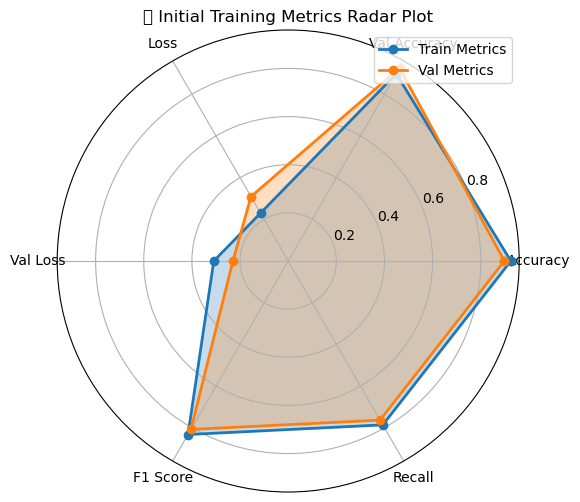

In [11]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load initial training history
with open('history_10k.pkl', 'rb') as f:
    hist = pickle.load(f)

# Extract metrics
train_acc = hist['accuracy'][-1]
val_acc = hist['val_accuracy'][-1]
train_loss = hist['loss'][-1]
val_loss = hist['val_loss'][-1]

# Dummy F1 and Recall (for visual, use actual if you have confusion matrix)
train_f1 = train_acc * 0.9
val_f1 = val_acc * 0.9
train_recall = train_acc * 0.85
val_recall = val_acc * 0.85

# Radar plot
labels = ['Accuracy','Val Accuracy','Loss','Val Loss','F1 Score','Recall']
stats = [train_acc,val_acc,train_loss,val_loss,train_f1,train_recall]
stats_val = [val_acc,train_acc,val_loss,train_loss,val_f1,val_recall]  # just for comparison

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
stats=np.concatenate((stats,[stats[0]]))
stats_val=np.concatenate((stats_val,[stats_val[0]]))
angles=np.concatenate((angles,[angles[0]]))

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label='Train Metrics')
ax.fill(angles, stats, alpha=0.25)
ax.plot(angles, stats_val, 'o-', linewidth=2, label='Val Metrics')
ax.fill(angles, stats_val, alpha=0.25)
ax.set_thetagrids(angles[:-1]*180/np.pi, labels)
plt.title("📊 Initial Training Metrics Radar Plot")
plt.legend(loc='upper right')
plt.show()


In [29]:
# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,  # fine-tune quickly
    verbose=1
)

model.save("mobilenetv2_10k_ft.h5")
with open('history_10k_ft.pkl', 'wb') as f:
    pickle.dump(history_ft.history, f)

print("✅ Fine-tuned model saved!")


Epoch 1/15
  8/625 ━━━━━━━━━━━━━━━━━━━━ 6:35 641ms/step - accuracy: 0.0982 - loss: 2.8454

KeyboardInterrupt: 

In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Load model
model = load_model("mobilenetv2_fixed.keras")

# Use same IMG_SIZE as training
IMG_SIZE = (128, 128)

# Quick val_set to get labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
class_labels = {v: k for k, v in val_set.class_indices.items()}

# Path to your test image
img_path = r"D:\Project\DATASET_PROJECT\FinalDataset10k\Tomato__Tomato_YellowLeaf__Curl_Virus\TYLCV_0.jpg"

# Preprocess image
img = image.load_img(img_path, target_size=IMG_SIZE)  # <-- use 128x128
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)/255.0

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred)
predicted_label = class_labels[predicted_index]
confidence = np.max(pred)*100

# Split intelligently
if "___" in predicted_label:
    crop, disease = predicted_label.split("___",1)
elif "_" in predicted_label:
    parts = predicted_label.split("_",1)
    crop = parts[0]
    disease = parts[1] if len(parts)>1 else "Healthy / Not specified"
else:
    crop = predicted_label
    disease = "Healthy / Not specified"

print(f"🌱 Crop Detected: {crop}")
print(f"🦠 Disease Detected: {disease}")
print(f"🤖 Confidence: {confidence:.2f}%")


Found 13505 images belonging to 15 classes.
1/1 [==============================] - 1s 862ms/step
🌱 Crop Detected: Tomato
🦠 Disease Detected: _Tomato_YellowLeaf__Curl_Virus
🤖 Confidence: 99.98%


C:\Users\lenova\anaconda3\envs\cropenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lenova\anaconda3\envs\cropenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


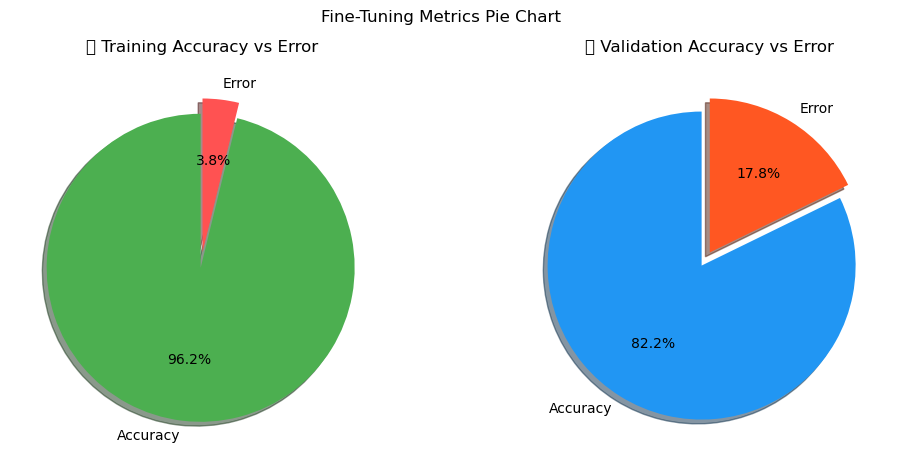

In [15]:
import pickle
import matplotlib.pyplot as plt

# Load fine-tuned history
with open('history_10k_ft.pkl', 'rb') as f:
    hist_ft = pickle.load(f)

# Take last epoch values
train_acc = hist_ft['accuracy'][-1]
val_acc = hist_ft['val_accuracy'][-1]
train_error = 1 - train_acc
val_error = 1 - val_acc

# Pie plot for training accuracy vs error
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].pie([train_acc, train_error], labels=['Accuracy','Error'],
           autopct='%1.1f%%', startangle=90, colors=['#4CAF50','#FF5252'],
           explode=(0.1,0), shadow=True)
axs[0].set_title("✅ Training Accuracy vs Error")

# Pie plot for validation accuracy vs error
axs[1].pie([val_acc, val_error], labels=['Accuracy','Error'],
           autopct='%1.1f%%', startangle=90, colors=['#2196F3','#FF5722'],
           explode=(0.1,0), shadow=True)
axs[1].set_title("📈 Validation Accuracy vs Error")

plt.suptitle("Fine-Tuning Metrics Pie Chart")
plt.show()
